# Predicting Global Conflict with LSTM Modeling 
### Mason Casebeer Notebook Walkthrough

#### Research Questions: How do interstate conflicts evolve over time; what trends do we see with respect to region, motivations, and intensity? Can we predict their conclusion and the method of their conclusion? 

In this project, we will be using the University of Uppsallas' dyadic conflict and conflict termination datasets to create an LSTM model which will try to predict trends in global conflicts in a region

## 1.0 Imports and loading datasets

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from IPython.display import Markdown, display
import seaborn as sns

dyadic = pd.read_csv('Dyadic_v25_1.csv')
aid = pd.read_csv('micFINAL.csv')
term = pd.read_csv('UCDPConflictTerminationDataset_v4_2024_Dyad.csv')

### 1.1 Loading dyadic dataset

in this cell we load in the dyadic dataset. we then merge conflicts on a year-region basis so we 
can aggregate conflict information across the 5 regions of the dataset

In [ ]:
# Aggregate dyadic events to a region-year dataset (1970-2023)

# split up multiple regions into separate rows (explode)
dyadic['region'] = dyadic['region'].str.split(',')
dyadic = dyadic.explode('region')
dyadic['region'] = dyadic['region'].astype(str).str.strip()         # remove " 3" -> "3"
dyadic['region'] = pd.to_numeric(dyadic['region'], errors='coerce').astype('Int64')
#region_single is depracated but i keep it for compatibility with future cells
dyadic['region_single'] = dyadic['region']
region_col = 'region_single'

#dataset goes from 1970 to 2023
years = list(range(1970, 2024))

# Ensure 'year' and intensity are numeric
dyadic['year'] = dyadic['year'].astype(int)
dyadic['intensity_level'] = pd.to_numeric(dyadic['intensity_level'], errors='coerce')

# Aggregation function
agg = dyadic.groupby([region_col, 'year']).agg(
ongoing_conflicts=('conflict_id', 'nunique'),
unique_dyads=('dyad_id', 'nunique'),
total_events=('dyad_id', 'count'),
avg_intensity=('intensity_level', 'mean'),
).reset_index()

# intensity dummies
intensity_ct = pd.crosstab([dyadic[region_col], dyadic['year']], dyadic['intensity_level']).rename(columns=lambda c: f'intensity_{int(c)}' if not pd.isna(c) else 'intensity_na').reset_index()

# conflict dummies
type_ct = pd.crosstab([dyadic[region_col], dyadic['year']], dyadic['type_of_conflict']).add_prefix('type_').reset_index()

# incompatability dummies
incompatibility_ct = pd.crosstab([dyadic[region_col], dyadic['year']], dyadic['incompatibility']).add_prefix('incomp_').reset_index()

# Merge aggregates and dummies
region_yearly = agg.merge(intensity_ct, left_on=[region_col, 'year'], right_on=[region_col, 'year'], how='left')
region_yearly = region_yearly.merge(type_ct, left_on=[region_col, 'year'], right_on=[region_col, 'year'], how='left')
region_yearly = region_yearly.merge(incompatibility_ct, left_on=[region_col, 'year'], right_on=[region_col, 'year'], how='left')

# Make sure all years are covered for all regions if they are missing years
regions = dyadic[region_col].dropna().unique().tolist()
full_index = pd.MultiIndex.from_product([regions, years], names=[region_col, 'year'])
region_yearly = region_yearly.set_index([region_col, 'year']).reindex(full_index).reset_index()

# Interpolate average intensity linearly within each region (not perfect since it's not really a scalar, but better than nothing)
# this is really the ratio between low and high intensity conflicts, not the average intensity itself
region_yearly['avg_intensity'] = (
region_yearly
.groupby(region_col)['avg_intensity']
.transform(lambda x: x.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill'))
)


# Handle missing values
num_cols = region_yearly.select_dtypes(include=['number']).columns.tolist()
# Exclude avg_intensity since we already interpolated
num_cols = [c for c in num_cols if c != 'avg_intensity']
region_yearly[num_cols] = region_yearly[num_cols].fillna(0)
obj_cols = [c for c in region_yearly.columns if c not in num_cols and c not in [region_col]]
region_yearly[obj_cols] = region_yearly[obj_cols].fillna('')


# Ensure integer columns where sensible
for c in ['ongoing_conflicts','unique_dyads','total_events']:
    if c in region_yearly.columns:
        region_yearly[c] = region_yearly[c].astype(int)

#Let's take a quick look! (uncollapse output if you want to see)
region_yearly.head(2)


/var/folders/z7/9fstfdd508xf6mc6bvczb8dh0000gn/T/ipykernel_92360/3476216312.py:49: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .transform(lambda x: x.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill'))


,region_single,year,ongoing_conflicts,unique_dyads,total_events,avg_intensity,intensity_1,intensity_2,type_1,type_2,type_3,type_4,incomp_1,incomp_2,incomp_3
0,4,1970,8,9,9,1.222222,7.0,2.0,4.0,0.0,4.0,1.0,8.0,1.0,0.0
1,4,1971,11,13,13,1.076923,12.0,1.0,4.0,0.0,7.0,2.0,7.0,6.0,0.0


### 1.2 Loading termination dataset

now we will load data from our termination dataset and merge it with the dyadic dataset

In [ ]:
# Ensure 'year' is numeric on the termination dataset
term['year'] = term['year'].astype(int)

#split up multiple regions into separate rows (explode)
term['region'] = term['region'].str.split(',')
term = term.explode('region')
term['region'] = term['region'].astype(str).str.strip()         # remove " 3" -> "3"
term['region'] = pd.to_numeric(term['region'], errors='coerce').astype('Int64')
#region_single is depracated but i keep it for compatibility with future cells
term['region_single'] = term['region']
region_col = 'region_single'


#term doesnt have region single yet so we need to map it over as well
if region_col not in term.columns:
    if region_col in dyadic.columns:
        mapping = dyadic.drop_duplicates(['conflict_id', region_col]).set_index('conflict_id')[region_col].to_dict()
        term[region_col] = term['conflict_id'].map(mapping)
    else:
        term[region_col] = ''

# Basic aggregates: number of terminated dyads and total termination events
term_agg = term.groupby([region_col, 'year']).agg(
    terminated_dyads=('dyad_id', 'nunique'),
    term_events=('dyad_id', 'count'),
    mode_outcome=('d_outcome', lambda x: x.mode().iloc[0] if not x.mode().empty else ''),
).reset_index()

# Outcome-type dummies (labeled with term_outcome_)
outcome_ct = pd.crosstab([term[region_col], term['year']], term['d_outcome']).add_prefix('term_outcome_').reset_index()

# Merge term aggregates and outcomes
term_yearly = term_agg.merge(outcome_ct, on=[region_col, 'year'], how='left')

# merge term features into region_yearly
region_yearly = region_yearly.merge(term_yearly, on=[region_col, 'year'], how='left')

# Fill missing numeric termination columns with 0 and strings with ''
term_num_cols = [c for c in region_yearly.columns if c in ['terminated_dyads','term_events'] or c.startswith('term_outcome_')]
for c in term_num_cols:
    if c in region_yearly.columns:
        region_yearly[c] = region_yearly[c].fillna(0).astype(int)

if 'mode_outcome' in region_yearly.columns:
    region_yearly['mode_outcome'] = region_yearly['mode_outcome'].fillna('')

# Diagnostic: uncomment to save to CSV
# region_yearly.to_csv('region_yearly_1970_2023.csv', index=False)

region_yearly['region_single'] = pd.to_numeric(region_yearly['region_single'])

#diagnostic print
print(region_yearly.dtypes)


region_single          int64
year                   int64
ongoing_conflicts      int64
unique_dyads           int64
total_events           int64
avg_intensity        float64
intensity_1          float64
intensity_2          float64
type_1               float64
type_2               float64
type_3               float64
type_4               float64
incomp_1             float64
incomp_2             float64
incomp_3             float64
terminated_dyads       int64
term_events            int64
mode_outcome          object
term_outcome_1.0       int64
term_outcome_2.0       int64
term_outcome_3.0       int64
term_outcome_4.0       int64
term_outcome_5.0       int64
term_outcome_6.0       int64
dtype: object


## 2.0 Data Exploration

We will now precede to an exploration of the data before we build or models to start predictions. This will help us answer the questions "How do interstate conflicts evolve over time?", as well as "what trends do we see with respect to region, motivations, and intensity?". 

### 2.1 Yearly conflicts and dyads by region

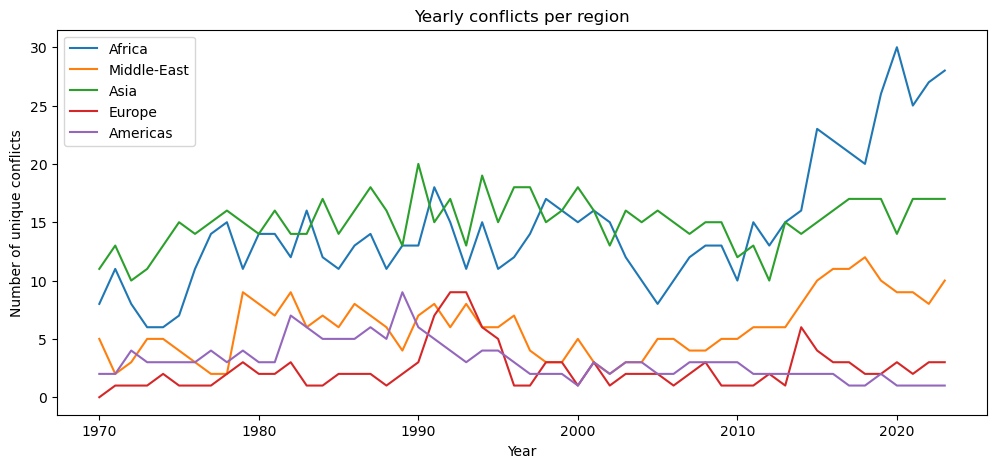

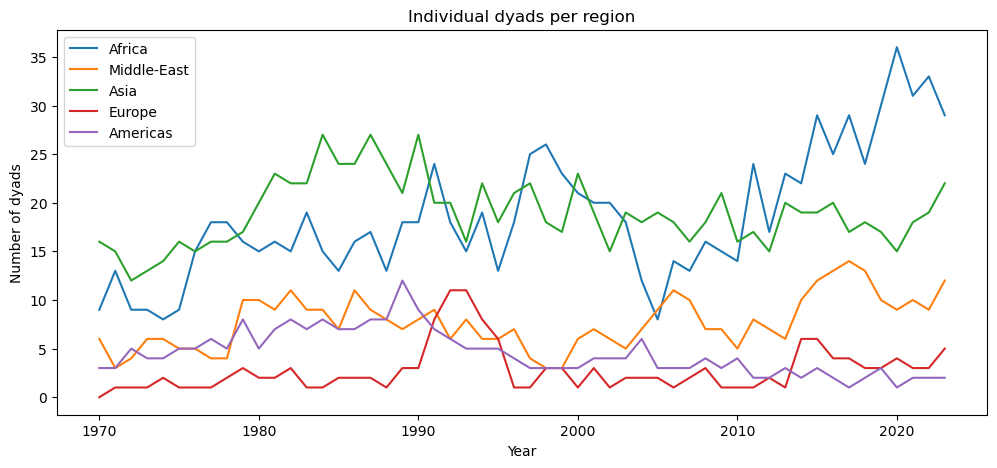

In [66]:
plt.figure(figsize=(12, 5))
region_lookup = {1:'Europe',2:'Middle-East',3:'Asia',4:'Africa',5:'Americas'}
regions= region_yearly['region_single'].unique()

for region in regions:
    region_data = region_yearly[region_yearly['region_single'] == region]
    plt.plot(region_data['year'],region_data['ongoing_conflicts'],label=region_lookup.get(int(region)))

plt.ylabel('Number of unique conflicts')
plt.xlabel('Year')
plt.title('Yearly conflicts per region')
plt.legend()
plt.show()

region_lookup = {1:'Europe',2:'Middle-East',3:'Asia',4:'Africa',5:'Americas'}
regions= region_yearly['region_single'].unique()

plt.figure(figsize=(12, 5))
for region in regions:
    region_data = region_yearly[region_yearly['region_single'] == region]
    plt.plot(region_data['year'],region_data['unique_dyads'],label=region_lookup.get(int(region)))

plt.ylabel('Number of dyads')
plt.xlabel('Year')
plt.title('Individual dyads per region')
plt.legend()
plt.show()

### 2.1 Analysis

We get some interesting results from our charts. One interesting trend is that Asia seems to beat out Africa in the late 1900s in terms of individual dyads, although they are even in terms of number of conflicts. This suggests conflicts in Asia had more parties involved and internal divisions than those in Africa. One worrying trend is that dyads and conflicts are both on a steep rise from ~2015 onwards. These charts certainly appear both stochastic and cyclic, suggesting that LSTSs may be a powerful tool for modeling them. 

### 2.2 Average Intensity

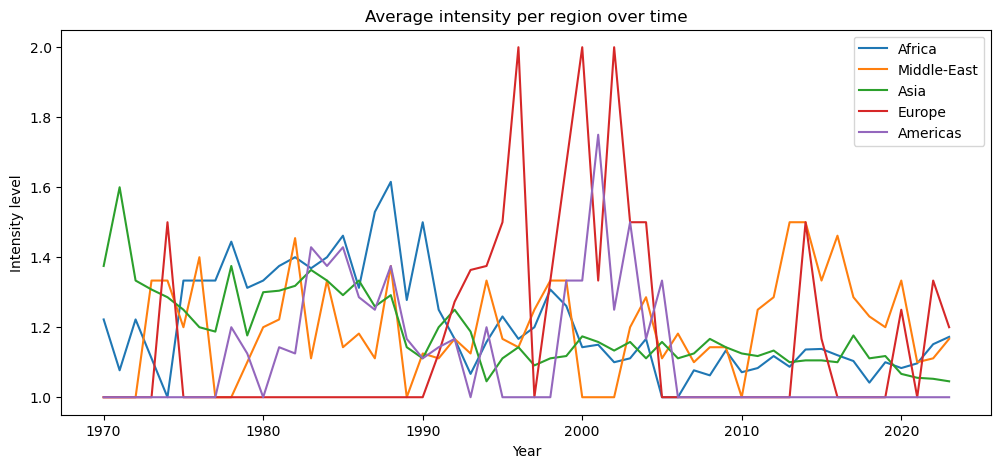

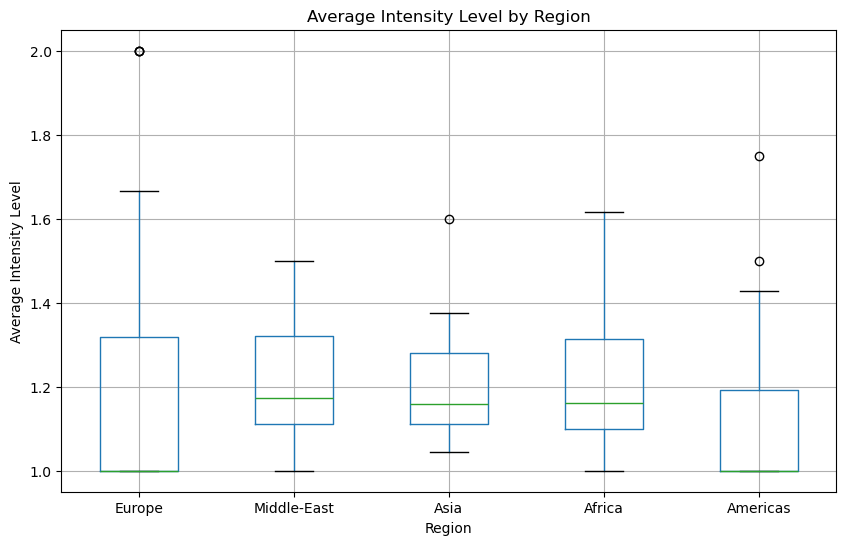

In [ ]:
plt.figure(figsize=(12, 5))
for region in regions:
    region_data = region_yearly[region_yearly['region_single'] == region]
    plt.plot(region_data['year'],region_data['avg_intensity'],label=region_lookup.get(int(region)))

plt.ylabel('Intensity level')
plt.xlabel('Year')
plt.title('Average intensity per region over time')
plt.legend()
plt.show()


# fig, [(ax0, ax1,ax2), (ax3, ax4,ax5)] = plt.subplots(nrows = 2,
#                                              ncols = 3, 
#                                              figsize=(15,10) 
#                                              )
# # ax_list = fig.axes
# # for i in range(5):
# #     ax_plot = ax_list[i]
# #     reg_plot = regions[i]
# #     region_data = region_yearly[region_yearly['region_single'] == reg_plot]
# #     x = region_data.avg_intensity
# #     ax_plot.boxplot(x.dropna())
# #     ax_plot.set_title( f"Intensity in {region_lookup.get(int(reg_plot))}")
# #     ax_plot.set_ylabel('Average Intensity Level')

# # for region in regions:
# #     region_data = region_yearly[region_yearly['region_single'] == region]

box_df = region_yearly.pivot(index='year', columns='region_single', values='avg_intensity')
box_df = box_df.rename(columns=region_lookup)  # map numeric region codes to names if available
plt.figure(figsize=(10,6))
box_df.boxplot()
plt.title('Average Intensity Level by Region')
plt.xlabel('Region')
plt.ylabel('Average Intensity Level')
plt.show()

### 2.2 Analysis

this is very imperfect because intensity is only between 1 and 2 (over or under 1000 deaths a year). Still, it gives us some idea of the types of conflicts that we see in regions in general. High intensity wars in Europe appear to coincide, while the Middle East, Asia, and Africa are full of low intensity conflicts.

### 2.3 Average peace outcomes

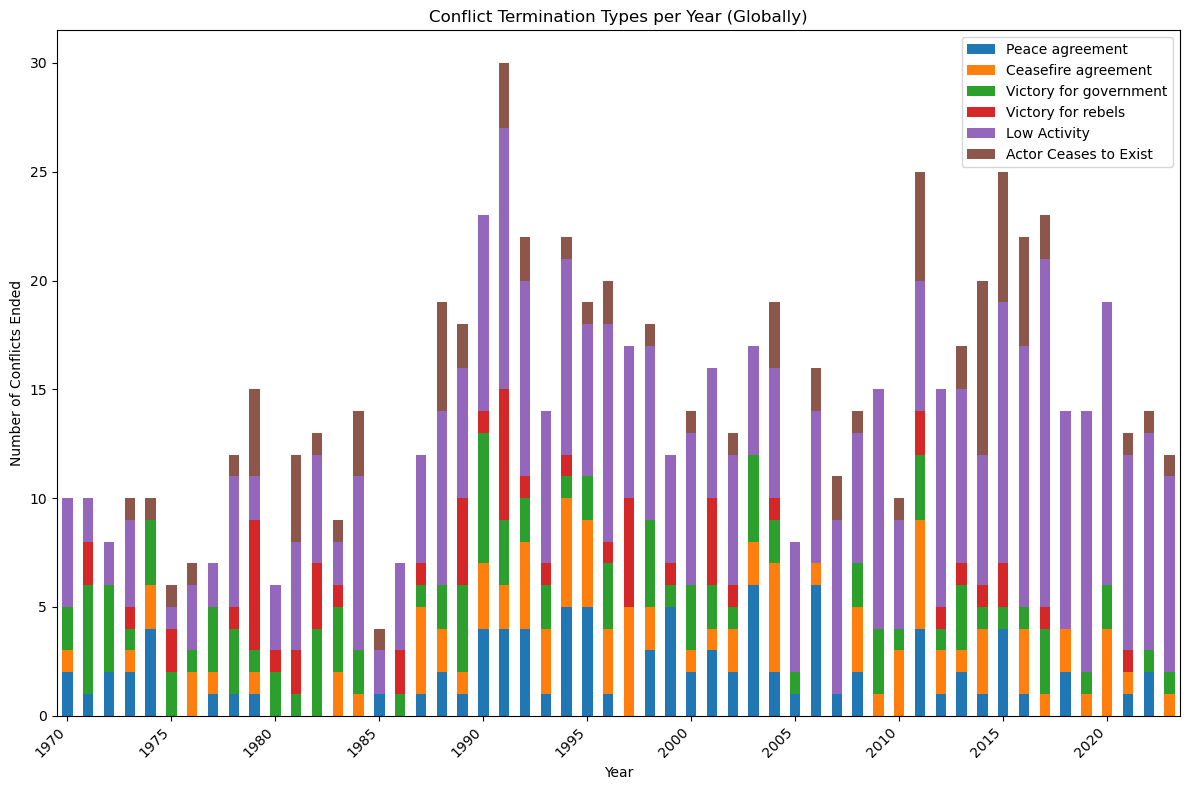

In [68]:
peace_types = ['term_outcome_1.0','term_outcome_2.0','term_outcome_3.0','term_outcome_4.0','term_outcome_5.0','term_outcome_6.0',]
peace_type_lookup = {'term_outcome_1.0':'Peace agreement','term_outcome_2.0':'Ceasefire agreement','term_outcome_3.0':'Victory for government','term_outcome_4.0':'Victory for rebels','term_outcome_5.0':'Low Activity','term_outcome_6.0':'Actor Ceases to Exist',}
region_yearly = region_yearly.sort_values('year')
region_agg = region_yearly.groupby('year')[peace_types].sum().reset_index()
region_agg = region_agg.rename(columns=peace_type_lookup)

plt.figure(figsize=(12, 8))

#switching to ax based plotting because it's better to generate a complex chart like this one 

ax = plt.gca()
region_agg.plot(
    x='year',
    y=list(peace_type_lookup.values()),
    kind='bar',
    stacked=True,
    ax=ax
)

ax.set_ylabel("Number of Conflicts Ended")
ax.set_xlabel("Year")
ax.set_title("Conflict Termination Types per Year (Globally)")

#ticks every 5 years
year_positions = range(len(region_agg))           # bar positions 0..N-1
year_labels = region_agg['year'].values           # actual year numbers

# choose every 5th index
indices_to_label = list(range(0, len(region_agg), 5))

ax.set_xticks(indices_to_label)
ax.set_xticklabels(year_labels[indices_to_label], rotation=45, ha='right')


ax.legend()
plt.tight_layout()
plt.show()

### 2.3 Analysis

This is another very interesting graph. We aggregated across the world to have the data be more easily readable. Historically, a lot of conflicts just petered out from the 1990s onward ("low activity"), but this has become even more common from about 2019 onward, which is an interesting trend. This may be related to the high number of civil wars and guerilla conflicts in recent history. As the borders for what define a conflict or even a militant group become fuzzier, so too do the processes through which these conflicts end 

### 2.4 What factors contribute to conflict termination?

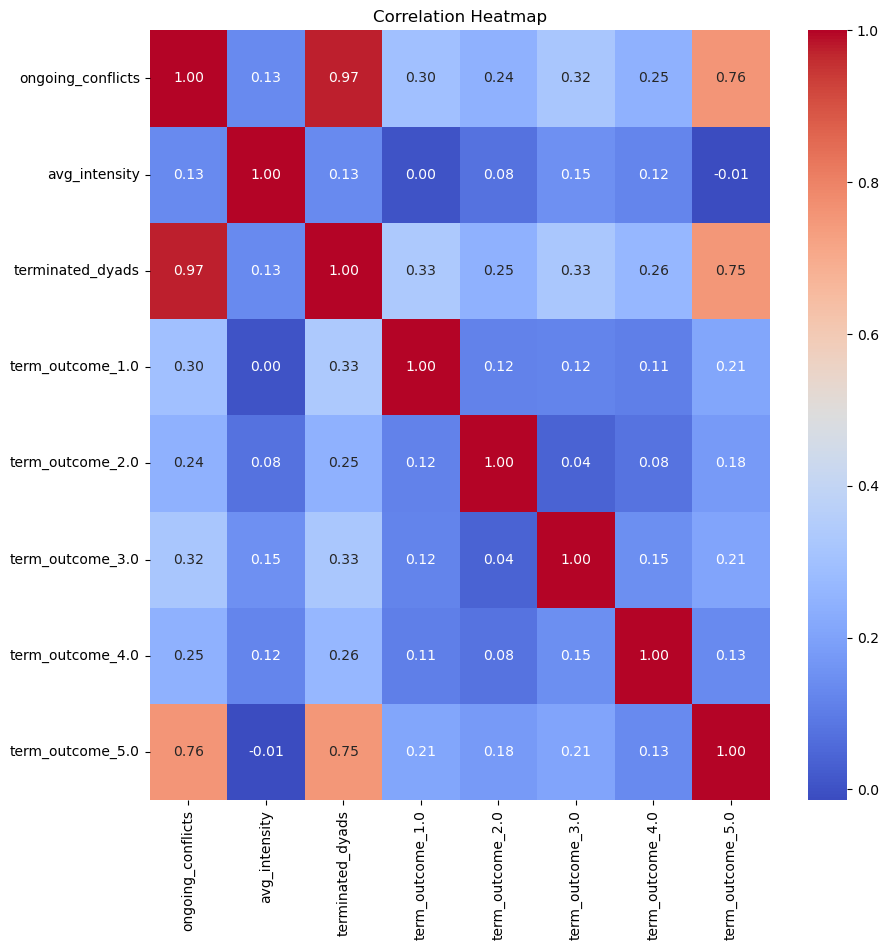

In [69]:
cols = [
    "ongoing_conflicts",
    "avg_intensity",
    "terminated_dyads",
    # 'incomp_1','incomp_2','incomp_3',
    "term_outcome_1.0", "term_outcome_2.0","term_outcome_3.0", "term_outcome_4.0", "term_outcome_5.0",
]

region_agg = region_yearly[cols]

corr_matrix = region_agg.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


### 2.5 Analysis

This heatmap is not especially enlightening since a lot of these variables are related. For example, it's not surprsie that the number of terminated dyads and the number of conflicts are very highly related, since there have to be dyads in a conflict in order for said conflict to terminate. 
For a better analysis, we will instead create a linear model and examine the weight of those variables.

## 3.0 Data Preparation

In [70]:
#call our data df for simplicity
df_predummy = region_yearly.copy()

dummies = pd.get_dummies(df_predummy['region_single'], prefix='region')
# Concatenate the dummy variables with the original DataFrame
df = pd.concat([df_predummy, dummies], axis=1)


features_cont = [
    # 'region_single',
    'ongoing_conflicts',
    'unique_dyads',
    'total_events',
    'intensity_1','intensity_2',
    'type_1','type_2','type_3','type_4',
    'region_1', 'region_2','region_3', 'region_4', 'region_5',
    'incomp_1','incomp_2','incomp_3',
]

# predicting number of dyads next year
target = 'unique_dyads'  

#create sequential dataset (for LSTM)
X_seq, y_labels = [], []
X_lin, y_lin = [], []
seq_len = 10

for region, group in df.groupby('region_single'):
    group = group.sort_values("year")
    X_cont = group[features_cont].values.astype(np.float32)
    y = group[target].values

    for t in range(len(X_cont) - seq_len):
        X_seq.append(X_cont[t : t + seq_len])   # ALWAYS length seq_len
        y_labels.append(y[t + seq_len])
    
    for t in range(len(X_cont) - 1):
        X_lin.append(X_cont[t])   # single time step
        y_lin.append(y[t + 1])





In [71]:
scaler = StandardScaler()
lin_scaler = StandardScaler()
# Clean continuous sequences (replace NaNs with 0 for scaling step)
X_clean = [np.nan_to_num(seq, nan=0.0) for seq in X_seq]
X_lin_clean = np.nan_to_num(X_lin, nan=0.0)

all_steps = np.concatenate(X_clean, axis=0)
scaler.fit(all_steps)
lin_scaler.fit(X_lin_clean)

X_scaled = [scaler.transform(seq) for seq in X_clean]
X_lin_scaled = lin_scaler.transform(X_lin_clean)

X_tensor = torch.stack([torch.tensor(seq, dtype=torch.float32) for seq in X_scaled])
y_tensor = torch.tensor(y_labels, dtype=torch.float32)

X_tensor_lin = torch.tensor(X_lin_scaled, dtype=torch.float32)
y_tensor_lin = torch.tensor(y_lin, dtype=torch.float32)

In [72]:
# Split continuous, categorical, and labels together
X_train,X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42
)

X_train_lin,X_test_lin, y_train_lin, y_test_lin = train_test_split(
    X_tensor_lin, y_tensor_lin, test_size=0.2, random_state=30
)

#turn into tensor datasets
train_ds = TensorDataset(X_train, y_train)
test_ds  = TensorDataset(X_test, y_test)

train_ds_lin = TensorDataset(X_train_lin, y_train_lin)
test_ds_lin  = TensorDataset(X_test_lin, y_test_lin)

#put into dataloder (this is how torch takes in data) 
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64)

train_loader_lin = DataLoader(train_ds_lin, batch_size=64, shuffle=True)
test_loader_lin  = DataLoader(test_ds_lin, batch_size=64)

NUM_EPOCHS = 61 #shared by lstm and linear

#diagnostic print
# print(X_tensor[0])
# print(y_tensor[0])


Our data is prepared and neatly packed into tensors that torch can operate on now. Next we create our LSTM. It will include a linear output layer because we are predicting a number (number of conflicts). It will use mean squared error. 

## 4.0 LSTM

In [73]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, n_cont, hidden_dim=64):
        super().__init__()
        #add some dropout to reduce risk of overfitting 
        self.lstm = nn.LSTM(n_cont, hidden_dim, batch_first=True, dropout = 0.2)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, cont_x):
        out, _ = self.lstm(cont_x)
        last = out[:, -1, :]#final timestep
        return torch.exp(self.fc(last)).squeeze(-1)#poisson



In [74]:
model = LSTM(n_cont=len(features_cont), hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

train_residuals = []  # to store residuals for all batches per epoch

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_residuals = []

    for x, y in train_loader:
        x = x.float()
        y = y.float()
        optimizer.zero_grad()
        preds = model(x).flatten()
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()        
        residuals = y - preds
        train_residuals.append(residuals.detach().cpu())  # detach from graph
    if(epoch%10==0):
        print("Epoch", epoch, "loss", float(loss))
train_residuals.append(torch.cat(train_residuals))




/Users/newuser/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 0 loss 143.16851806640625
Epoch 10 loss 183.4167022705078
Epoch 20 loss 133.05943298339844
Epoch 30 loss 168.48062133789062
Epoch 40 loss 115.4737777709961
Epoch 50 loss 94.9470443725586
Epoch 60 loss 21.3354549407959
Epoch 30 loss 168.48062133789062
Epoch 40 loss 115.4737777709961
Epoch 50 loss 94.9470443725586
Epoch 60 loss 21.3354549407959


In [75]:
#handle residuals for future plotting/analysis use

model.eval()
val_residuals_per_epoch = []
with torch.no_grad():
    for x_val, y_val in test_loader:
        x_val = x_val.float()
        y_val = y_val.float()

        preds_val = model(x_val).flatten()
        residuals_val = y_val - preds_val
        val_residuals_per_epoch.append(residuals_val.cpu())

val_residuals_per_epoch.append(torch.cat(val_residuals_per_epoch))




## 5.0 Linear Regression

comparing our LSTM to a linear regression will give us a good baseline to compare how succesful our LSTM was at predicting future conflicts compared to a more naive approach. Examining the weights of the final values will also show what values are potentially interesting.

In [76]:
num_features = X_train_lin.shape[1] #should be 18

class LinearRegressionModel(torch.nn.Module):

    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

lin_model = LinearRegressionModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(lin_model.parameters(), lr=0.01)

for epoch in range(NUM_EPOCHS):
    # loss = criterion(pred_y, y_data)
    for x, y in train_loader_lin:
        x = x.float()
        y = y.float()
        optimizer.zero_grad()
        preds = lin_model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()        
    if(epoch%10==0):
        print('epoch {}, loss {}'.format(epoch, loss.item()))

weights_1d = lin_model.linear.weight.detach().cpu().numpy().ravel()  # shape (num_features,)
for i in range(num_features):
    print(f"Weight of {features_cont[i]}: {weights_1d[i]}")

print("Bias:", lin_model.linear.bias.detach().cpu().numpy())

epoch 0, loss 148.46859741210938
epoch 10, loss 78.32955932617188
epoch 20, loss 105.07893371582031
epoch 30, loss 56.25303649902344
epoch 40, loss 83.60629272460938
epoch 50, loss 29.943639755249023
epoch 60, loss 45.58201599121094
Weight of ongoing_conflicts: 0.059702806174755096
Weight of unique_dyads: 0.07119232416152954
Weight of total_events: -0.16510362923145294
Weight of intensity_1: -0.05904293432831764
Weight of intensity_2: -0.011146376840770245
Weight of type_1: 0.03036995604634285
Weight of type_2: 0.017432982102036476
Weight of type_3: 0.11972717940807343
Weight of type_4: 0.030108073726296425
Weight of region_1: -0.027027027681469917
Weight of region_2: -0.031585268676280975
Weight of region_3: 0.01846463233232498
Weight of region_4: -0.03040383569896221
Weight of region_5: -0.06587468832731247
Weight of incomp_1: 0.060725219547748566
Weight of incomp_2: 0.1513908952474594
Weight of incomp_3: 0.01396903395652771
Bias: [10.505725]


/Users/newuser/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/newuser/miniconda3/envs/ml/lib/python3.10/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## 6.0 Results and Conclusion

### 6.1 LSTM Residual Analysis 

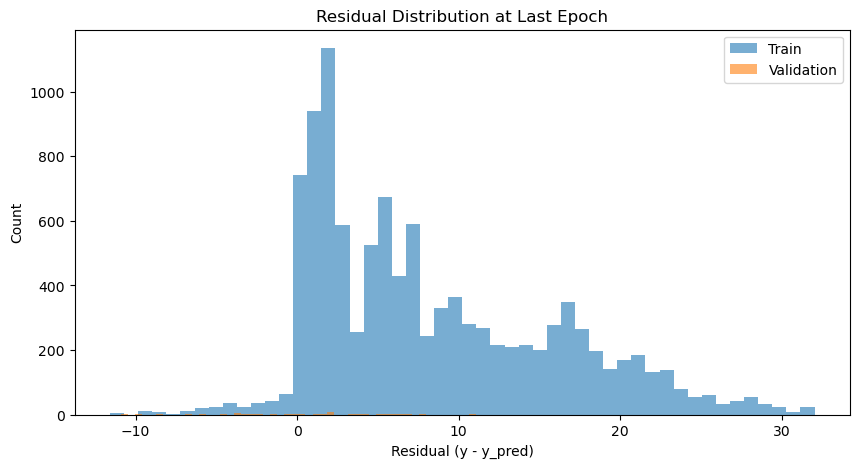

In [77]:
# Example: plot last epoch residuals
plt.figure(figsize=(10,5))

plt.hist(train_residuals[-1].numpy(), bins=50, alpha=0.6, label='Train')
plt.hist(val_residuals_per_epoch[-1].numpy(), bins=50, alpha=0.6, label='Validation')

plt.xlabel('Residual (y - y_pred)')
plt.ylabel('Count')
plt.title('Residual Distribution at Last Epoch')
plt.legend()
plt.show()


By epoch 60, our model had an average MSE of approx 25 conflicts^2, meaning it could guess the number of conflicts in the next year with an accuracy of around 5 conflicts. 

Residual analysis gives us some interesting feedback. It is centered around 5 and is very heavily right skewed, implying our model tends to under-estimate conflicts and has a really hard time capturing sudden spikes in conflicts. My research shows that LSTMs commonly have trouble underpredicting because of large spikes in stochastic data.

## Comparison of LSTM and Linear Regression

With an MSE of around 20 conflictsˆ2 for the LSTM compared to 50 conflictsˆ2 for the linear regression, we see that the LSTM approach to modeling conflicts worldwide has potential. This also indicates that the outbreak or termination of conflicts is a complex process, depending on historical trends as well as current events.

